# Tutorial 1 – Simulating a Simple Example

This example provides a basic 3-component, 2 reaction system with A → B and B → C, where the kinetic rate constants are fixed.

### Load required modules

In [16]:
from kipet.library.common.charts import make_plot
from kipet.library.TemplateBuilder import *
from kipet.library.PyomoSimulator import *

import matplotlib.pyplot as plt
import sys

### Use TemplateBuilder to insert data and kinetic model

In [17]:
builder = TemplateBuilder()  

We use the required TemplateBuilder class to begin creating our model. This class is required for every KIPET example and allows the user to construct the Pyomo model in the background. While the user does not need to interact with this line, it is useful to realise its importance. The lines that follow allow us to define the components that we expect to be present in the mixture.

In [18]:
builder.add_mixture_component('A', 0.1)
builder.add_mixture_component('B', 0.0)
builder.add_mixture_component('C', 0.0)

Where the first function input is the name of the component and the second input is the initial concentration in the mixture. Following this is the next required user input, the definition of the kinetic parameters:

In [19]:
builder.add_parameter('k1', 2.0)
builder.add_parameter('k2', 0.2)

Following the definition of our basic reaction system, every KIPET model requires a set of ODEs to be defined. Please note that KIPET requires that every component that is identified in the mixture has an expression. The ODEs are inputted in the following way for this example:

In [20]:
def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = -m.P['k1']*m.Z[t,'A']
    exprs['B'] = m.P['k1']*m.Z[t,'A']-m.P['k2']*m.Z[t,'B']
    exprs['C'] = m.P['k2']*m.Z[t,'B']
    return exprs

After defining the equations in this way we can add them to our template which will create the Pyomo model using:

In [23]:
builder.set_odes_rule(rule_odes)

So now that the model is defined we can decide what to do with it. In this example the goal is to simulate the known reaction system and obtain concentration vs time profiles.

### PyomoSimulator

We will do this by sending our “builder” model through the PyomoSimulator class, which discretizes the system and solves an optimization problem using orthogonal collocation on finite elements. Firstly, we define our pyomo model using our builder TemplateBuilder:

In [24]:
pyomo_model = builder.create_pyomo_model(0.0,10.0)

Where the two arguments are the time period that we would like to simulate over. We then pass this new model onto the PyomoSimulator class:

In [25]:
simulator = PyomoSimulator(pyomo_model)

and apply the discretization that we would like for the ODEs:

In [26]:
simulator.apply_discretization('dae.collocation', nfe = 60, ncp = 3,scheme = 'LAGRANGE-RADAU')

The arguments that need to be supplied use the same keywords as the pyomo.dae method. And need to include all the arguments above. Where “nfe” is the number of finite elements, the higher the number the more accurate your solution is likely to be but at the cost of higher computational costs. “ncp” is the number of collocation points within each finite element. As this number increases, the computational costs increase dramatically and the chances of a converged/feasible solution decrease. The “scheme” refers to the type of collocation to be applied, with two options available to users, either collocation using Lagrange-Radau (as above) roots or using Lagrange-Legendre (scheme=’LAGRANGE-LEGENDRE’). It is highly recommended that the user use Lagrange-Radau (which is also the default option if the argument is omitted) as this has been shown to produce more numerical stability for complex problems, such as the ones usually encountered in KIPET. Finally we are ready to run the simulation in Pyomo with the following line:

In [27]:
results_pyomo = simulator.run_sim('ipopt', tee=False)

where ‘ipopt’ is the IPOPT nonlinear program (NLP) optimization solver and the option “tee” is to stream the solver output to the console. For more information on additional arguments, please refer to the function guide in section 5.2.

### Visualizing and viewing results

Finally, to view the results of the optimization-based simulation we use the matlplotlib function

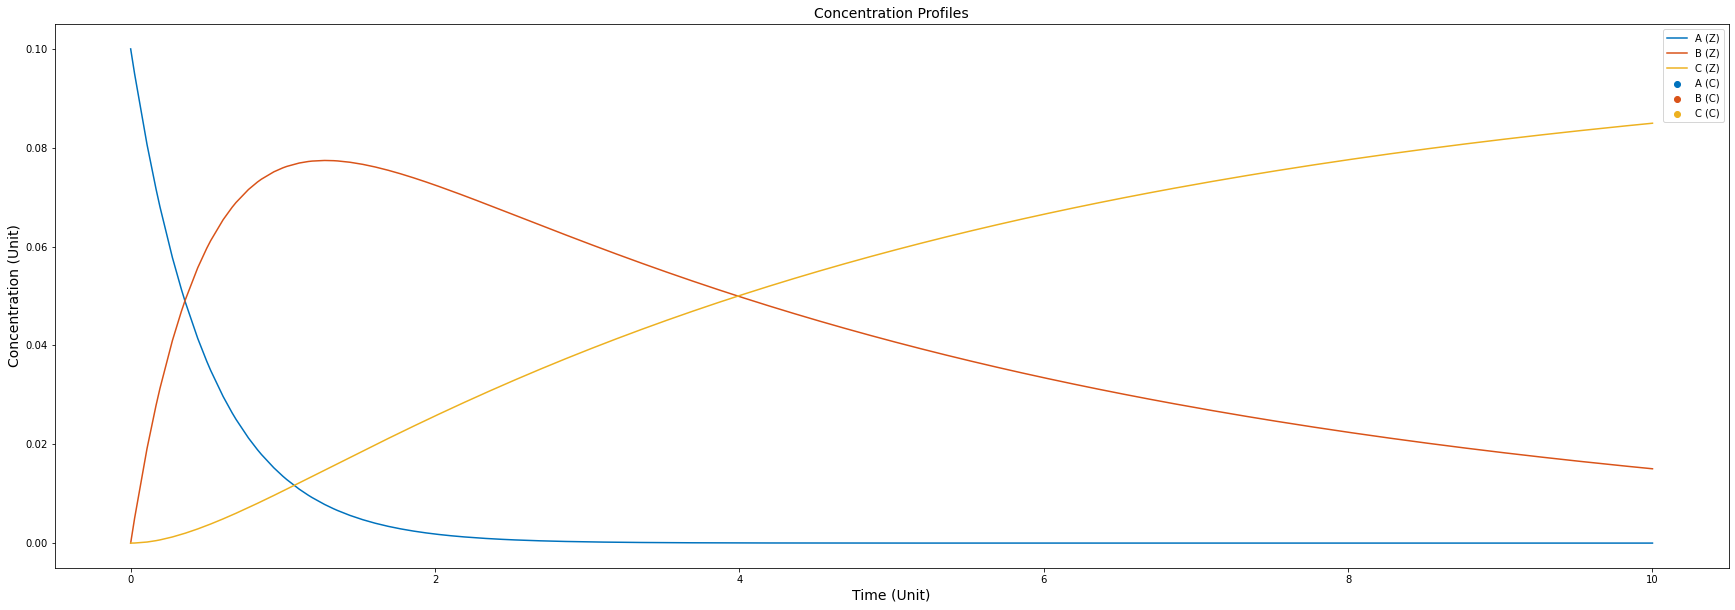

In [32]:
make_plot(results_pyomo, 'C')

Where we are plotting the concentration vs time graph with the unnoised concentration, Z. The plot obtained from this example is shown in the figure.